# Ivy AlexNet demo


In this demo, we show how an [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/) model written in Ivy native code, can be used for image classification, and integrated with all three of the major ML frameworks: PyTorch, TensorFlow and JAX.

# Imports

Since we want the packages to be available after installing, after running the first cell, the notebook will automatically restart.

You can then do **Runtime -> Run all** after the notebook has restarted, to run all of the cells.

Make sure you run this demo with GPU enabled!

In [ ]:
!pip install -q ivy
!pip install -q dm-haiku

!git clone https://github.com/unifyai/models.git
!cd models && python3 -m pip install -q -e .

exit()

# Data Preparation

First we need to download the ImageNet classes and preprocess the image.

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [2]:
filename = "models/images/cat.jpg"

In [3]:
# Preprocess torch image
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings('ignore')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])
torch_img = Image.open(filename)
torch_img = preprocess(torch_img)
torch_img = torch.unsqueeze(torch_img, 0)

img = torch_img.numpy()

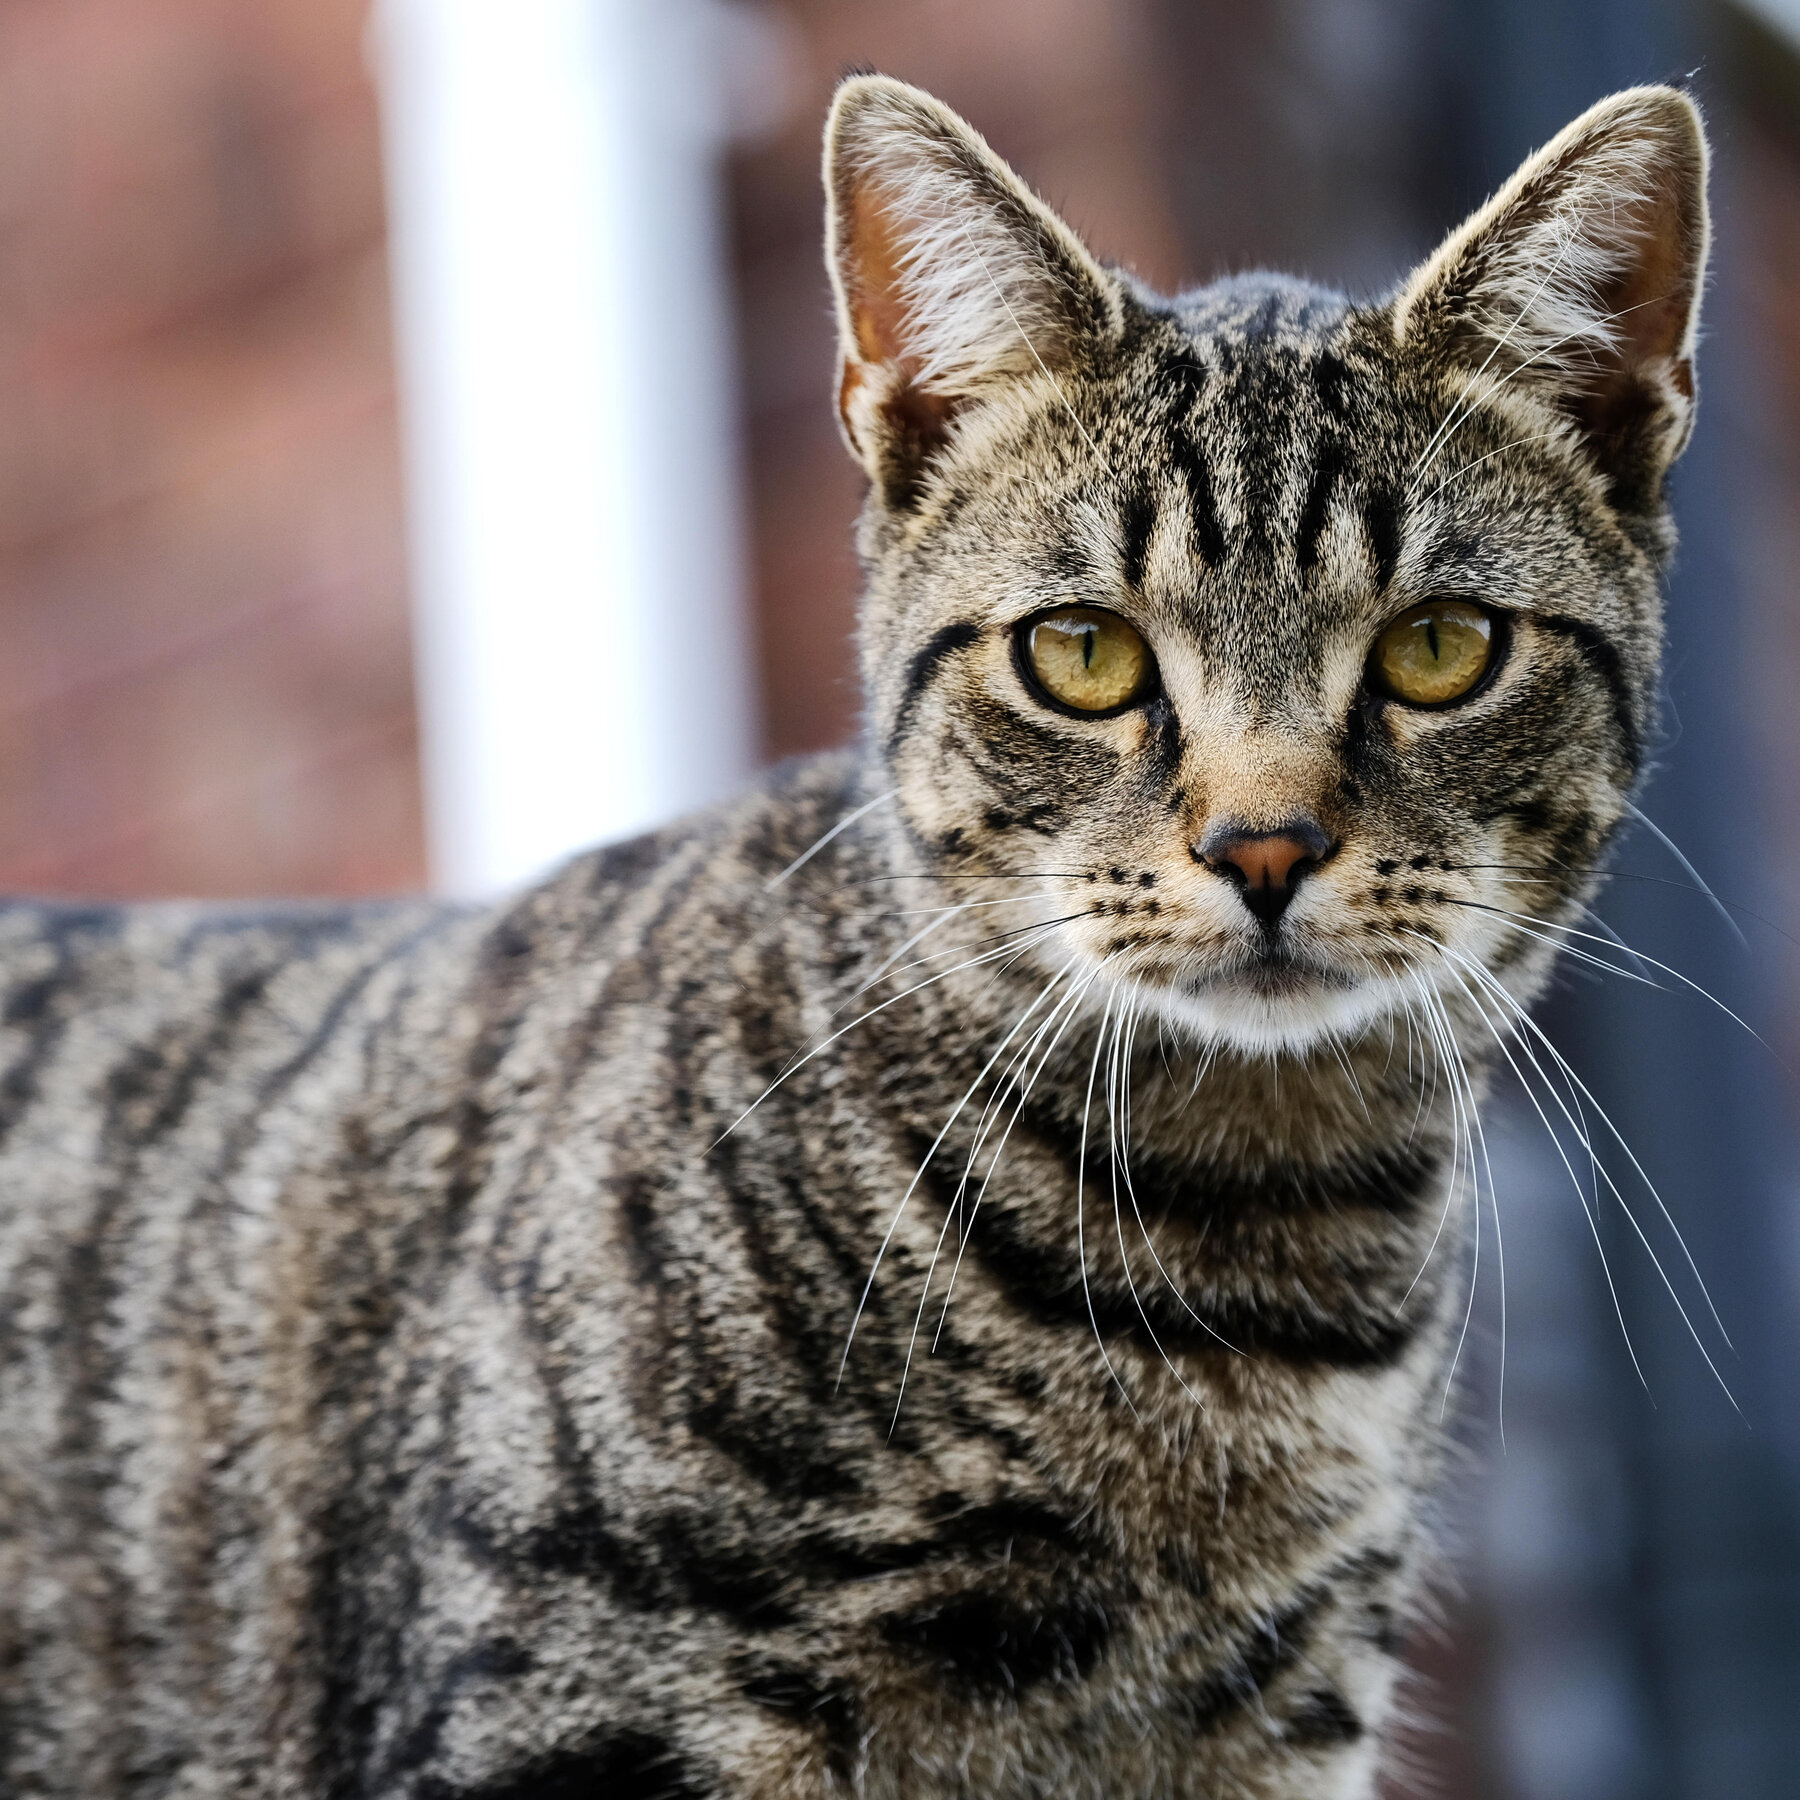

In [4]:
from IPython.display import Image, display
display(Image(filename))

# Ivy AlexNet inference in Torch

We import the Ivy native implementation of AlexNet. The code for this model is given at the end of this notebook, [click here to see it.](#scrollTo=W3KxYC7pIr_p)

In [ ]:
import ivy
ivy.set_backend("torch")

from ivy_models.alexnet import alexnet
ivy_alexnet = alexnet()

In order to make sure the model is as quick as possible, we can call `ivy.compile()`. This can take a moment, but is a one-time cost.


In [ ]:
ivy_alexnet = ivy.compile(ivy_alexnet, args=(ivy.asarray(torch_img.cuda()),))

In [7]:
output = ivy.softmax(ivy_alexnet(ivy.asarray(img)))  # pass the image to the model
classes = ivy.argsort(output[0], descending=True)[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.to_list()])

Indices of the top 3 classes are: ivy.array([282, 281, 285], dev=gpu:0)
Logits of the top 3 classes are: ivy.array([0.64773697, 0.29496649, 0.04526037], dev=gpu:0)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


We can check to confirm that the model gets the same results as the torchvision implementation.

In [8]:
import torchvision
from torchvision.models import alexnet as torch_alexnet
from torchvision.models import AlexNet_Weights

torch_alexnet = torch_alexnet(weights=AlexNet_Weights.IMAGENET1K_V1, dropout=0).to("cuda")

In [9]:
torch_output = torch.softmax(torch_alexnet(torch_img.cuda()), dim=1)
torch_classes = torch.argsort(torch_output[0], descending=True)[:3]
torch_logits = torch.take(torch_output[0], torch_classes)

print("Indices of the top 3 classes are:", torch_classes)
print("Logits of the top 3 classes are:", torch_logits)
print("Categories of the top 3 classes are:", [categories[i] for i in torch_classes])

Indices of the top 3 classes are: tensor([282, 281, 285], device='cuda:0')
Logits of the top 3 classes are: tensor([0.6477, 0.2950, 0.0453], device='cuda:0', grad_fn=<TakeBackward0>)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


Great! We can see that the classes and corresponding logits are the same in the Ivy native model and the torchvision model.

# TensorFlow inference

With an Ivy native model, it is simple to change the backend, which lets us use the model in a different framework. First we'll try TensorFlow.


In [10]:
import tensorflow as tf
ivy.set_backend("tensorflow")
ivy_alexnet = alexnet()

Once the backend is set to TensorFlow, we can use TensorFlow to do our logit post-processing.

In [11]:
output = tf.nn.softmax(ivy_alexnet(ivy.asarray(img)))  # pass the image to the model
classes = tf.argsort(output[0], axis=-1, direction="DESCENDING")[:3]  # get the top 3 classes
logits = tf.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.numpy().tolist()])

Indices of the top 3 classes are: tf.Tensor([282 281 285], shape=(3,), dtype=int32)
Logits of the top 3 classes are: tf.Tensor([0.6477362  0.29496726 0.04526032], shape=(3,), dtype=float32)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


As expected, the results are identical to the Torch backend! If you had another model or postprocessing routine written in TensorFlow, Ivy makes it simple to feed one into the other, without having to (carefully) rewrite them all to one backend. It also means you can easily try out different backends to see which one is the quickest for your particular model and hardware.

Again, we can call ivy.compile to speed up inference.

In [12]:
ivy_alexnet = ivy.compile(ivy_alexnet, args=(ivy.asarray(img),))

Repeating the previous inference, we see that the compiled model gets the same results as before, and is faster.

In [13]:
output = tf.nn.softmax(ivy_alexnet(ivy.asarray(img)))  # pass the image to the model
classes = tf.argsort(output[0], axis=-1, direction="DESCENDING")[:3]  # get the top 3 classes
logits = tf.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in classes.numpy().tolist()])

Indices of the top 3 classes are: tf.Tensor([282 281 285], shape=(3,), dtype=int32)
Logits of the top 3 classes are: tf.Tensor([0.6477362  0.29496726 0.04526032], shape=(3,), dtype=float32)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


# JAX inference

Next is the JAX backend. In order to take advantage of the speed of JAX, we're going to need to transpile the module to a Haiku module, which we can then use jax.jit on.

In [ ]:
import jax
import haiku as hk

ivy.set_backend("jax")
ivy_alexnet = alexnet()

Using ivy.transpile to transpile the model to a Haiku module. This may take a little while, but only needs to be done once.

In [15]:
img_jax = jax.numpy.asarray(img)
jax_alexnet = ivy.transpile(ivy_alexnet, to="haiku", args=(img_jax,))

In [16]:
def forward(x):
  module = jax_alexnet()
  return module(x)

forward = hk.transform(forward)
rng = hk.PRNGSequence(jax.random.PRNGKey(42))
params = forward.init(next(rng), img_jax)
apply = jax.jit(forward.apply)

In [17]:
logits = apply(params, next(rng), img_jax)
output = jax.nn.softmax(logits)  # pass the image to the model
classes = jax.numpy.argsort(-output[0])[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in np.array(classes).tolist()])

Indices of the top 3 classes are: [282 281 285]
Logits of the top 3 classes are: ivy.array([0.64773661, 0.29496688, 0.04526027], dev=gpu:0)
Categories of the top 3 classes are: ['tiger cat', 'tabby', 'Egyptian cat']


We get the exact same results as before. Note again that we were able to use JAX functions in calculating the top three classes.

Let's try another image

In [18]:
filename = 'models/images/dog.jpg'
# Preprocess torch image
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])
torch_img = Image.open(filename)
torch_img = preprocess(torch_img)
torch_img = torch.unsqueeze(torch_img, 0)

img = torch_img.numpy()

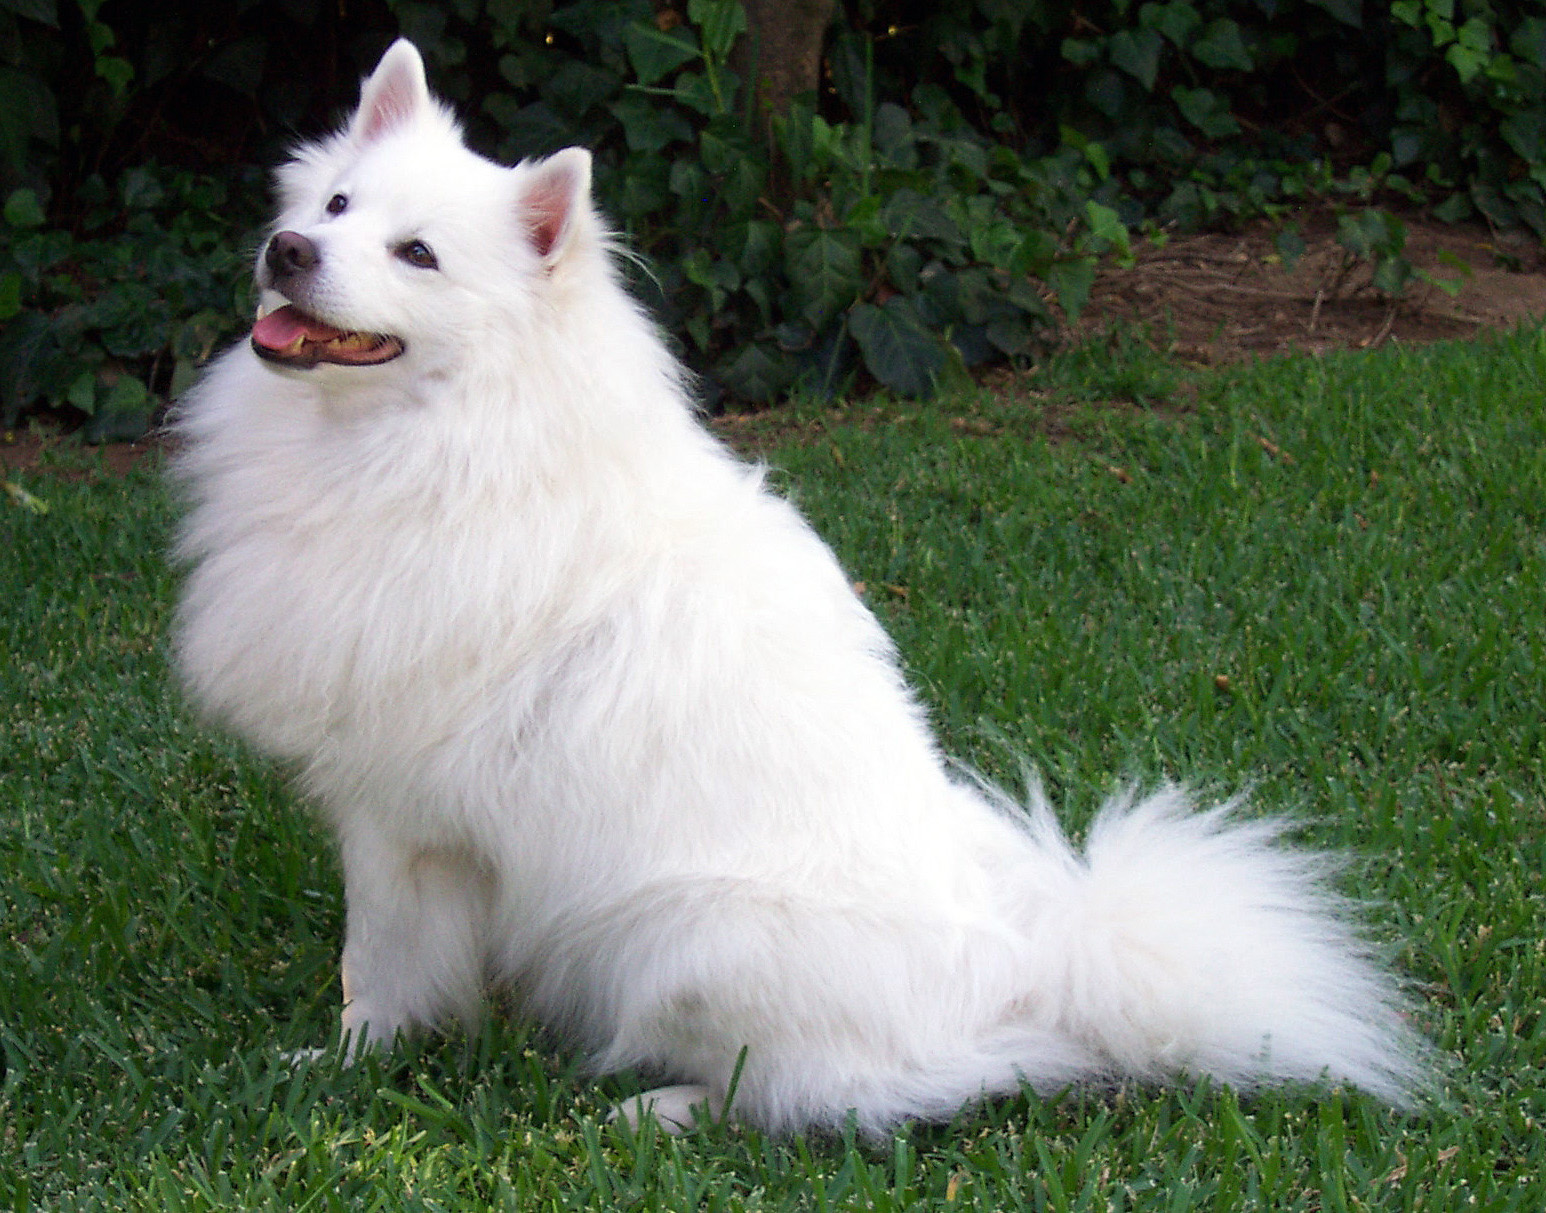

In [19]:
from IPython.display import Image, display
display(Image(filename))

In [20]:
img_jax = jax.numpy.asarray(img)
logits = apply(params, next(rng), img_jax)
output = jax.nn.softmax(logits)  # pass the image to the model
classes = jax.numpy.argsort(-output[0])[:3]  # get the top 3 classes
logits = ivy.gather(output[0], classes)  # get the logits

print("Indices of the top 3 classes are:", classes)
print("Logits of the top 3 classes are:", logits)
print("Categories of the top 3 classes are:", [categories[i] for i in np.array(classes).tolist()])

Indices of the top 3 classes are: [258 104 259]
Logits of the top 3 classes are: ivy.array([0.7244764 , 0.13937844, 0.05874981], dev=gpu:0)
Categories of the top 3 classes are: ['Samoyed', 'wallaby', 'Pomeranian']


Note that the incorrect prediction of "*wallaby*" is down to the AlexNet model itself, as the torchvision version returns the same logits!  

In [21]:
torch_output = torch.softmax(torch_alexnet(torch_img.cuda()), dim=1)
torch_classes = torch.argsort(torch_output[0], descending=True)[:3]
torch_logits = torch.take(torch_output[0], torch_classes)

print("Indices of the top 3 classes are:", torch_classes)
print("Logits of the top 3 classes are:", torch_logits)
print("Categories of the top 3 classes are:", [categories[i] for i in torch_classes])

Indices of the top 3 classes are: tensor([258, 104, 259], device='cuda:0')
Logits of the top 3 classes are: tensor([0.7245, 0.1394, 0.0587], device='cuda:0', grad_fn=<TakeBackward0>)
Categories of the top 3 classes are: ['Samoyed', 'wallaby', 'Pomeranian']


# Appendix (Ivy code for AlexNet implementation)

As promised, here is the Ivy native source code for the AlexNet model used in this demo.

In [22]:
class AlexNet(ivy.Module):
    """An Ivy native implementation of AlexNet"""

    def __init__(self, num_classes=1000, dropout=0, v=None):
        self.num_classes = num_classes
        self.dropout = dropout
        super(AlexNet, self).__init__(v=v)

    def _build(self, *args, **kwargs):
        self.features = ivy.Sequential(
            ivy.Conv2D(3, 64, [11, 11], [4, 4], 2, data_format="NCHW"),
            ivy.ReLU(),
            ivy.MaxPool2D(3, 2, 0, data_format="NCHW"),
            ivy.Conv2D(64, 192, [5, 5], [1, 1], 2, data_format="NCHW"),
            ivy.ReLU(),
            ivy.MaxPool2D(3, 2, 0, data_format="NCHW"),
            ivy.Conv2D(192, 384, [3, 3], 1, 1, data_format="NCHW"),
            ivy.ReLU(),
            ivy.Conv2D(384, 256, [3, 3], 1, 1, data_format="NCHW"),
            ivy.ReLU(),
            ivy.Conv2D(256, 256, [3, 3], 1, 1, data_format="NCHW"),
            ivy.ReLU(),
            ivy.MaxPool2D(3, 2, 0, data_format="NCHW"),
        )
        self.avgpool = ivy.AdaptiveAvgPool2d((6, 6))
        self.classifier = ivy.Sequential(
            ivy.Dropout(prob=self.dropout),
            ivy.Linear(256 * 6 * 6, 4096),
            ivy.ReLU(),
            ivy.Dropout(prob=self.dropout),
            ivy.Linear(4096, 4096),
            ivy.ReLU(),
            ivy.Linear(4096, self.num_classes),
        )

    def _forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = ivy.reshape(x, (x.shape[0], -1))
        x = self.classifier(x)
        return x